<a href="https://colab.research.google.com/github/weezah/04_BattleTank/blob/master/stable_diffusion_generation_export_05112022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> generate with stable diffusion & friends


- original model https://huggingface.co/CompVis/stable-diffusion-v1-4 
- a good blog post https://huggingface.co/blog/stable_diffusion
- diffusers [repo](https://github.com/huggingface/diffusers)


this inference notebook by [Peter](https://github.com/pszemraj)



---



## setup


In [1]:
#@markdown setup logging
import logging
from pathlib import Path
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
das_logfile = Path.cwd() / "SD_generate.log"

logging.basicConfig(
    level=logging.INFO,
    filename=das_logfile,
    filemode='w',
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%m/%d/%Y %I:%M:%S",
)
print(f'logfile is at:\n\n{das_logfile}')

logfile is at:

/content/SD_generate.log


In [2]:
#@markdown check  system stats
from psutil import virtual_memory
import os
ram_gb = round(virtual_memory().total / (1024**3), 1)
print(f'Runtime has {ram_gb} gigs of memory and {os.cpu_count()} processors')
logging.info(f'Runtime has {ram_gb} gigs of memory and {os.cpu_count()} processors')

Runtime has 12.7 gigs of memory and 2 processors


In [3]:
!nvidia-smi

Wed Nov 16 14:44:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%capture
#@markdown set up auto-formatting of cells in notebook

from IPython.display import HTML, display


def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )
get_ipython().events.register("pre_run_cell", set_css)

In [5]:
!pip install transformers diffusers accelerate ftfy -q
!pip install -U yake gensim -q # filename utils

     |████████████████████████████████| 5.5 MB 4.8 MB/s 
     |████████████████████████████████| 304 kB 57.0 MB/s 
     |████████████████████████████████| 175 kB 69.6 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 182 kB 62.0 MB/s 
     |████████████████████████████████| 7.6 MB 46.5 MB/s 
     |████████████████████████████████| 60 kB 3.4 MB/s 
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
     |████████████████████████████████| 132 kB 52.6 MB/s 


In [6]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler, EulerDiscreteScheduler

### download weights


In [11]:
#@markdown you have to go to [the model repository](https://huggingface.co/runwayml/stable-diffusion-v1-5)
#@markdown login & get access to the model. 
#@markdown - _You have to do that for EACH model you want to use here. The access gets tied to your login token_
#@markdown - Then, go to your [hf settings page](https://huggingface.co/settings/profile), generate a token for read-only, paste it below.
model_id = "runwayml/stable-diffusion-v1-5" #@param ["runwayml/stable-diffusion-v1-5", "nitrosocke/mo-di-diffusion"]
model_short_name = model_id.split('/')[-1]
diffusion_scheduler = ""


In [12]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


<font color="orange"><strong><center> LOGIN IN THE ABOVE CELL

In [14]:
#@markdown load model, scheduler
device = "cuda" if torch.cuda.is_available() else "cpu"

lms = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear"
)
try:
    euler_scheduler = EulerDiscreteScheduler.from_config(
        model_id, subfolder="scheduler"
    )
    scheduler = euler_scheduler
except Exception as e:
    print(f"error loading EulerDiscreteScheduler, defaulting to LMS scheduler {e}")
    scheduler = lms
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    use_auth_token=True,
    scheduler=scheduler,
    torch_dtype=torch.float16,
)
pipe = pipe.to(device)
print(f"loaded onto device:\t{device}")


Downloading:   0%|          | 0.00/308 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/617 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

loaded onto device:	cuda


---




 ## run pipeline in inference 
 
 - (sample random noise and denoise)



In [15]:
from datetime import datetime
import time
from tqdm.auto import tqdm
from pathlib import Path
import shutil
import random
from os.path import join
import yake
from gensim.parsing.preprocessing import remove_stopwords

# @markdown utilies & prompt augmentation
def get_timestamp():
    return datetime.now().strftime("%b-%d-%Y_%H-%M")


def clean_clean_stringstr_path(
    text: str,
    is_filename=True,
    no_stopwords=True,
):
    """simple helper fn to remove chars colab unix paths don't like"""

    text = remove_stopwords(text) if no_stopwords else text
    cln = text.replace(",", "").replace(".", "")

    return cln.replace(" ", "_" if is_filename else "-")


import re


def clean_str_path(
    string: str,
    is_filename=True,
    no_stopwords=True,
):

    string = remove_stopwords(string) if no_stopwords else string
    _nc = "_" if is_filename else "xxxxx"
    string = re.sub(r"\s+", _nc, string)
    string = re.sub(r"[^\w\s]", "", string)
    return string.replace("xxxxx", "-")


def get_kw_basic(text: str):
    """utility to get kw from prompt for file names"""
    kw_extractor = yake.KeywordExtractor(
        top=5,
        dedupLim=0.2,
    )
    keywords = kw_extractor.extract_keywords(text)

    joined_kw = " ".join([kw[0] for kw in keywords])

    return joined_kw


def prompt_aug(
    prompt: str,
    aug_type="random",
    prompt_order="random",
):
    """
    prompt_aug - augment prompt with strings from a list of augmentation types
    Args:
        prompt (str): prompt to augment
        aug_type (str, optional): type of augmentation to use. Defaults to "random".
        prompt_order (str, optional): order to use for augmentation. Defaults to "random".
    Returns:
        str: augmented prompt
    """

    aug_phrases = {
        "default": "digital art",
        "oil": "an oil painting",
        "watercolor": "a watercolor painting",
        "unreal": "an Unreal Engine render",
        "impressionist": "an Impressionist painting",
        # populate with ideas from YOUR brain
    }

    if aug_type == "random":
        aug_s = random.SystemRandom().choice(list(aug_phrases.keys()))
        aug = aug_phrases[aug_s]
    else:
        aug = "digital art"
    if prompt_order.lower() == "last":
        aug_prompt = f"{aug} depicting {prompt}."
    elif prompt_order.lower() == "first":
        aug_prompt = f"{prompt}, as {aug}."
    else:
        aug_prompt = random.choice(
            [
                f"{prompt}, as {aug}.",
                f"{aug} depicting {prompt}.",
            ]
        )
    aug_prompt = aug_prompt.replace(".,", ",")
    aug_prompt = aug_prompt.replace("  ", " ")
    return aug_prompt.replace("..", ".")


In [16]:
# @title params

dirs = [shutil.rmtree(d) for d in Path.cwd().iterdir() if d.is_dir()]
prompt = "i cooka da pasta"  # @param {type:"string"}

n_imgs_deep = 10 #@param {type:"slider", min:5, max:50, step:5}
n_imgs_wide = 1  # simultaneous image generation, would
prompts = n_imgs_deep * [prompt]
basename = clean_str_path(f"{prompt[:30]}-{get_timestamp()}")

outdir = Path.cwd() / basename
outdir.mkdir(exist_ok=True)

num_inference_steps = 350  # @param {type:"slider", min:50, max:500, step:50}
h = 768  # @param ["512", "768", "256"] {type:"raw"}
w = 512  # @param ["512", "768", "256"] {type:"raw"}
guidance_scale = 8.5  # @param {type:"slider", min:1, max:15, step:0.5}
eta = 0.25  # @param {type:"slider", min:0, max:1, step:0.05}
file_type = "png"  # @param ["jpg", "png"]
augment_prompt = True  # @param {type:"boolean"}

_dir_name = clean_str_path(
    get_kw_basic(prompt)[:40],
    is_filename=False,
)


In [17]:
# where is it putting stuff???
!pwd
!ls

/content
cooka_da_pastaNov162022_1451  SD_generate.log


In [18]:
# @title generate
images = []
print(f"base prompt:\t{prompt}")
logging.info(f"starting:\t{prompt}")

for i, prompt in tqdm(enumerate(prompts), total=len(prompts), desc="generating images"):

    if augment_prompt:
        full_prompt = prompt_aug(prompt, prompt_order="random")
        logging.info(f"augmented run {i} with:\t{full_prompt}")
    else:
        full_prompt = prompt
        logging.info(f"visualizing:\t{full_prompt}")
    st = time.perf_counter()
    result = pipe(
        [full_prompt],
        num_inference_steps=num_inference_steps,
        eta=eta,
        guidance_scale=guidance_scale,
        height=h,
        width=w,
    )

    _is_nsfw = result["nsfw_content_detected"][0]
    _im = result.images[0]

    im_name = clean_str_path(f"img {i} - {full_prompt[:60]}")
    _im_out = outdir / f"{im_name}.{file_type}"
    _im.save(_im_out)
    rt = round((time.perf_counter() - st) / 60, 2)


base prompt:	i cooka da pasta


generating images:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

In [19]:
# fyi - stopped generation loop early in this demo manually to save time
!ls $outdir


img_0__oil_painting_depicting_cooka_da_pasta.png
img_1__cooka_da_pasta_Unreal_Engine_render.png
img_2__digital_art_depicting_cooka_da_pasta.png
img_3__Impressionist_painting_depicting_cooka_da_pasta.png
img_4__cooka_da_pasta_Unreal_Engine_render.png
img_5__cooka_da_pasta_digital_art.png
img_6__oil_painting_depicting_cooka_da_pasta.png
img_7__watercolor_painting_depicting_cooka_da_pasta.png
img_8__cooka_da_pasta_Unreal_Engine_render.png
img_9__cooka_da_pasta_Unreal_Engine_render.png


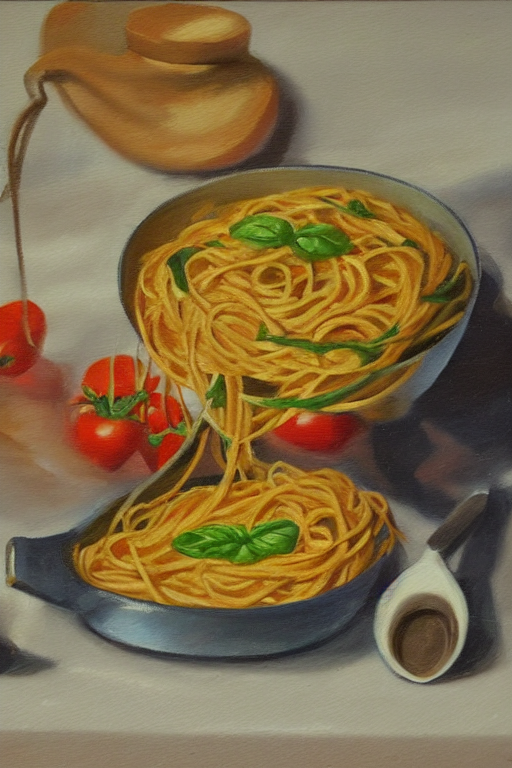

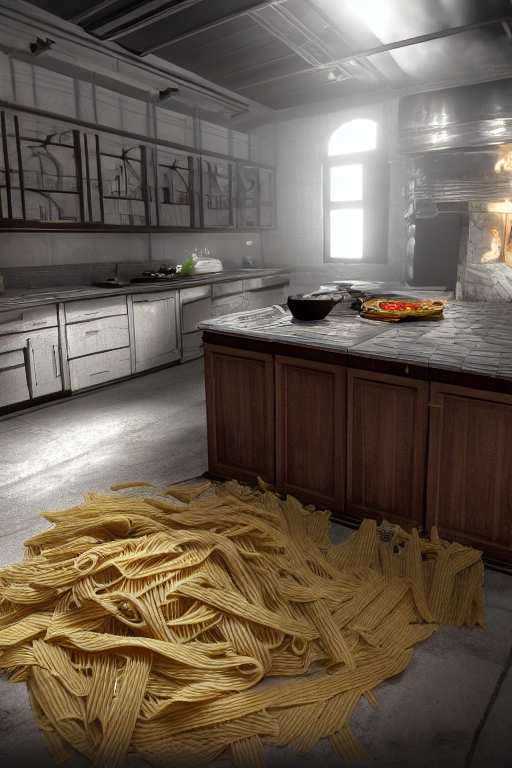

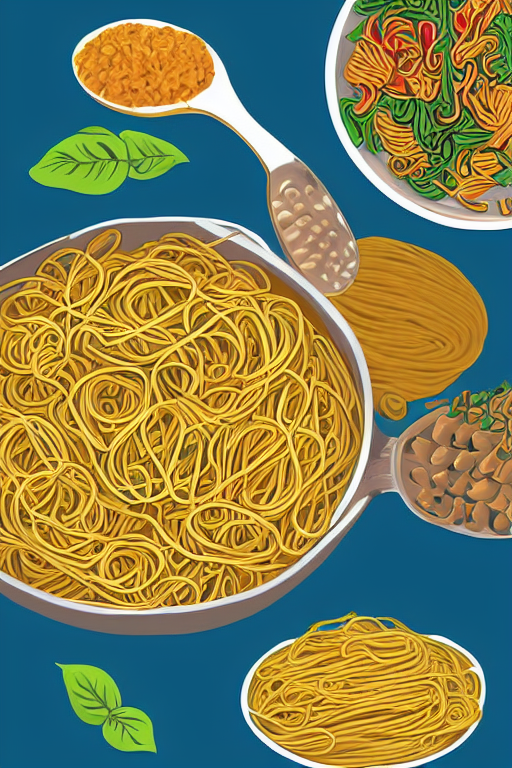

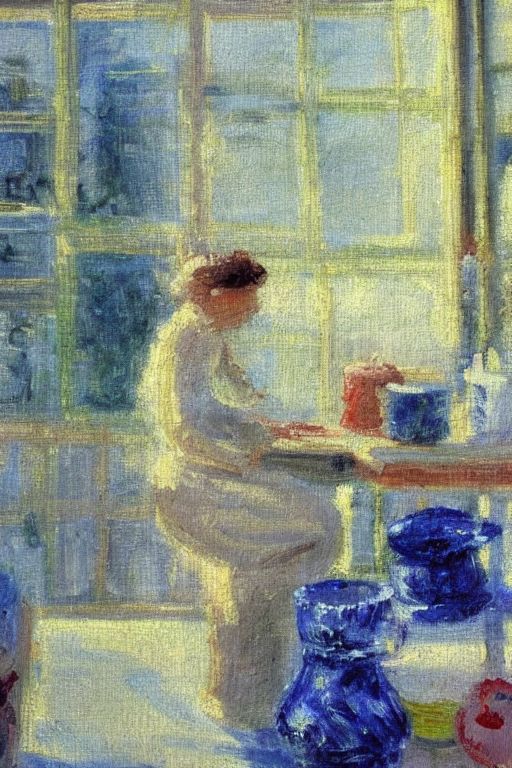

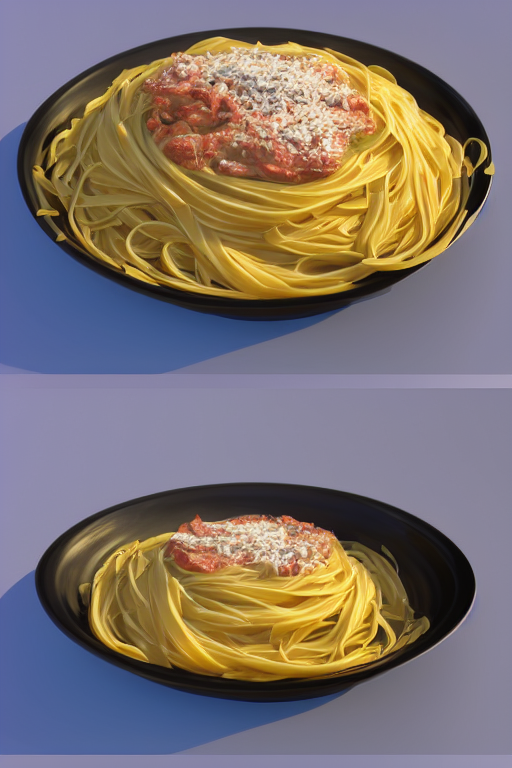

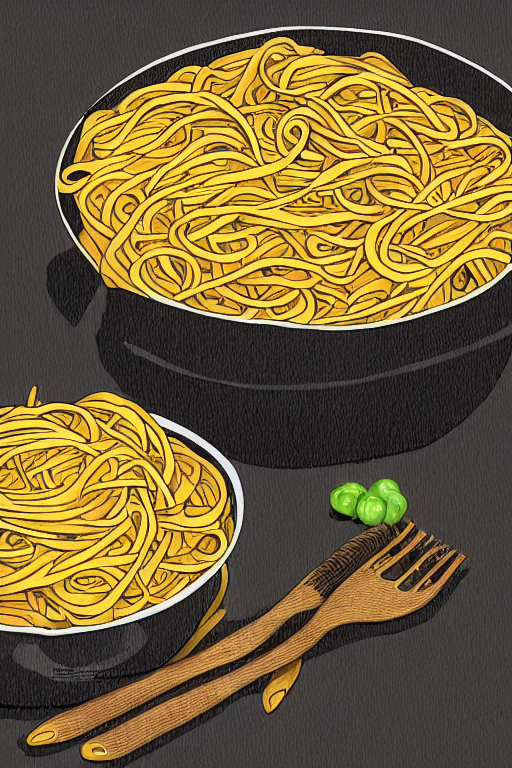

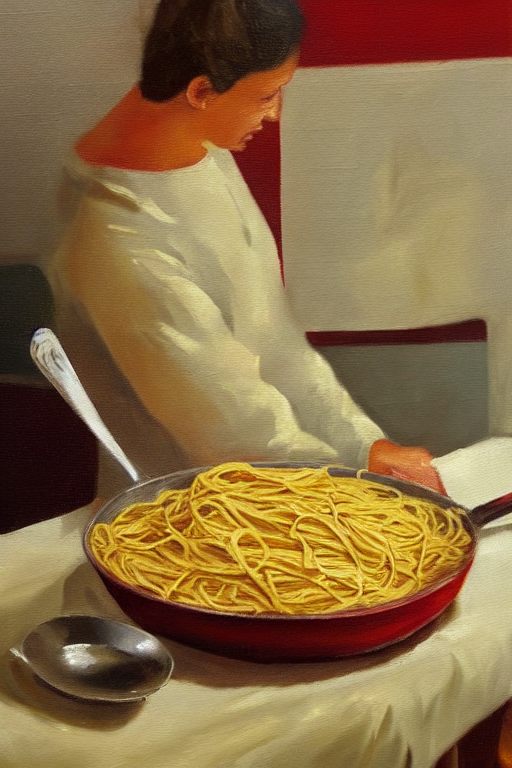

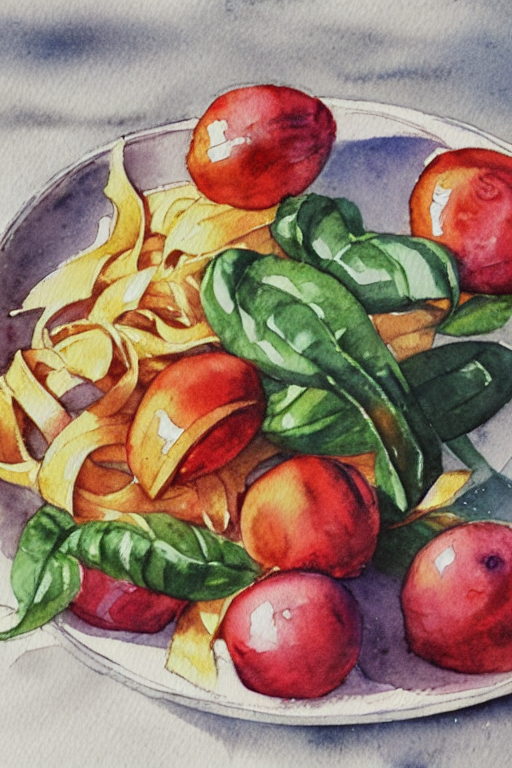

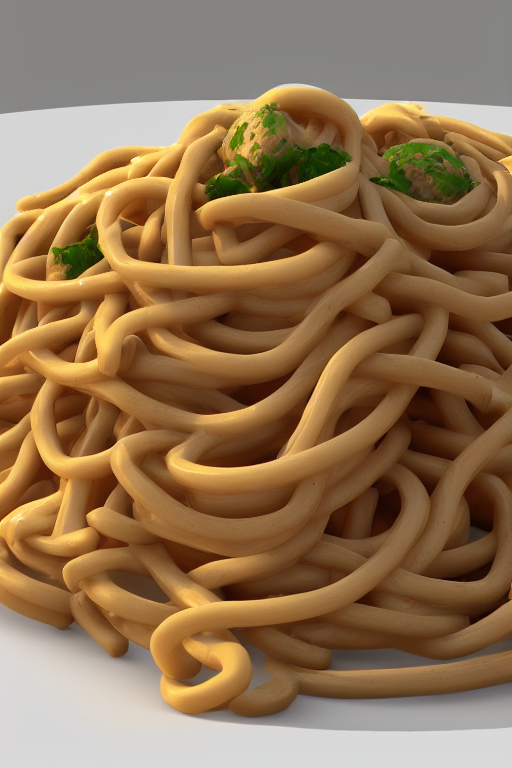

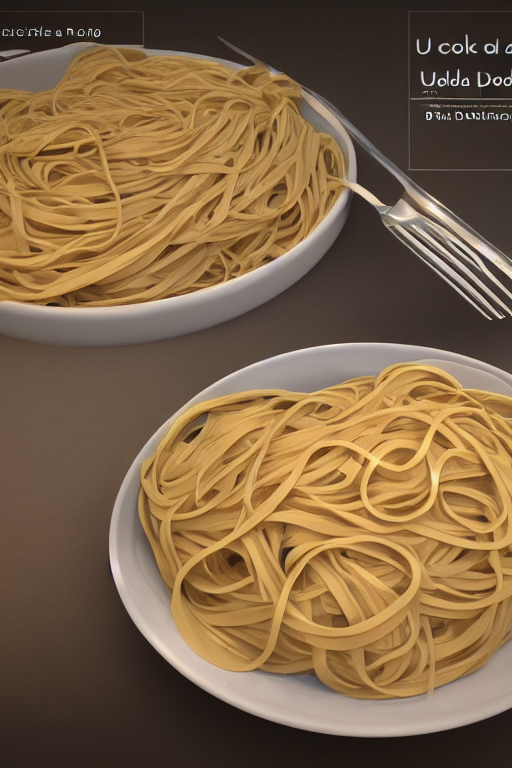

In [52]:
from IPython.display import Image
from IPython.display import display

images_path = !ls $outdir

images = []
for i in images_path:
  img = outdir / i
  images.append(Image(img))


display(*images)

---


In [ ]:
export_zip = True #@param {type:"boolean"}
from google.colab import files

if export_zip:
    _zip_name = f"output_{outdir.name}.zip"
    # _out = str(outdir.resolve())
    !zip -9 -j -r $_zip_name $outdir 
    files.download(_zip_name)


  adding: img_1__watercolor_painting_depicting_cooka_da_pasta.jpg (deflated 0%)
  adding: img_0__cooka_da_pasta_watercolor_painting.jpg (deflated 0%)
  adding: img_2__cooka_da_pasta_Unreal_Engine_render.jpg (deflated 2%)
  adding: labelled_cooka da pasta.png (deflated 0%)
  adding: generation_parameters.json (deflated 31%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>